# How displacements resolve into line-of-sight
    
A notebook to explore the expected differences between interferograms ascending and descending viewing geometries for forward modeled displacements of earthquake slip using the Okada elastic dislocation model

This notebook draws heavily on the 'Line-of-sight components and the Okada model' notebook. We won't go over all that again, but will use the code snippets to project the same model into ascending and descending viewing geometries.

Let's start by importing some dependencies:

In [6]:
%matplotlib inline
from okada_wrapper import dc3d0wrapper, dc3dwrapper
from numpy import linspace, zeros, log
from math import sin, cos, tan, radians
from matplotlib.pyplot import contourf, contour,\
    xlabel, ylabel, title, colorbar, show, savefig
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import matplotlib.pyplot as plt
import time

And let's set some parameters! We need to set fault parameters, geometric parameters and elastic parameters.

In [56]:
# fault parameters
strike=90
dip=85
rake=-1
slip=2
as_length=15000  # along-strike length
dd_width=10000   # down-dip width
cd_depth=6000   # centroid depth
xs=0  # x cooordinate of center of up-dip projection of the fault
ys=0  # y coordinate of same

# # geometric parameters
# asc_inc = 39   # incidence of ascending track (degrees from horizontal)
# asc_pnt = -260  # pointing direction of ascending track (degrees counter-clockwise from north)
# dsc_inc = 39   # incidence of descending track (degrees from horizontal)
# dsc_pnt = -100  # pointing direction of descending track (degrees counter-clockwise from north)

# geometric parameters
asc_inc = 34   # incidence of ascending track (degrees from horizontal)
asc_pnt = -260  # pointing direction of ascending track (degrees counter-clockwise from north)
dsc_inc = 34   # incidence of descending track (degrees from horizontal)
dsc_pnt = -100  # pointing direction of descending track (degrees counter-clockwise from north)

# elastic parameters
lmda = 30e9  # 30 GPa is a standard value for continental crust
mu = 30e9    # 30 GPa is also a standard value for continental crist
alpha = (lmda + mu) / (lmda + 2 * mu) # elastic constant used by Okada

The necessary prep work for running the Okada model is in this snippet. We have to account for centroid position, rotate coordinates to account for strike, and decompose slip and rake into slip components.

In [57]:
# calculate the centroid coordinates
rc=cd_depth/tan(radians(dip))  # radial surface distance from (xs,ys) to centroid
rcx=rc*sin(radians(strike+90)) # coordinate shift in x from xs to centroid 
rcy=rc*cos(radians(strike+90)) # coordinate shift in y from ys to centroid
xc=xs+rcx  # x coordinate of centroid
yc=ys+rcy  # y coordinate of centroid

# make a rotation matrix to account for strike
R=np.array([[cos(radians(strike-90)), -sin(radians(strike-90))], 
            [sin(radians(strike-90)), cos(radians(strike-90))]])

# convert slip and rake to strike-slip and dip-slip
ss=slip*cos(radians(rake))
ds=slip*sin(radians(rake))

This snippet runs the forward Okada model, using the parameters we specified before.

In [58]:
# set up a grid for computation
n = (101, 101)
x = linspace(-25000, 25000, n[0])  # these are the plot bounds
y = linspace(-25000, 25000, n[1])

UX = zeros((n[0], n[1]))  # and these three arrays contain the output
UY = zeros((n[0], n[1]))
UZ = zeros((n[0], n[1]))

    
# loop through the points on your grid
for i in range(n[0]):
    for j in range(n[1]):
            
        # shift and rotate the coordinates into Okada geometry
        P=np.array([[x[i]-xc],[y[j]-yc]]); # observation point wrt centroid in map coordinates
        Q=R.dot(P)                         # observation point rotated into Okada geometry
            
        # run the Okada dc3d function on the rotated coordinates   
        success, u, grad_u = dc3dwrapper(alpha,
                                            [Q[0], Q[1], 0],
                                            cd_depth, dip,
                                            [-as_length/2, as_length/2], 
                                            [-dd_width/2, dd_width/2],
                                            [ss, ds, 0.0])
        assert(success == 0)
        
        # here u[0] is strike-parallel displacement and u[1] is strike-normal displacement
        UX[i, j] = u[0]*sin(radians(strike))-u[1]*cos(radians(strike))   # x displacement
        UY[i, j] = u[0]*cos(radians(strike))-u[1]*sin(radians(strike))   # y displacement
        UZ[i, j] = u[2]   # z displacement
        

Project these displacements into line-of-sight for the two viewing geometries we defined before. And then plot everything!

In [59]:
# calculate the line-of-sight vectors for each viewing geometry
p_vec_asc = [sin(radians(asc_pnt))*sin(radians(asc_inc)), -cos(radians(asc_pnt))*sin(radians(asc_inc)), -cos(radians(asc_inc))];
p_vec_dsc = [sin(radians(dsc_pnt))*sin(radians(dsc_inc)), -cos(radians(dsc_pnt))*sin(radians(dsc_inc)), -cos(radians(dsc_inc))];

# let's scale the three displacement components we calculated by these pointing vector components
ULOS_ASC_X = np.multiply(UX,p_vec_asc[0]) 
ULOS_ASC_Y = np.multiply(UY,p_vec_asc[1]) 
ULOS_ASC_Z = np.multiply(UZ,p_vec_asc[2]) 

ULOS_DSC_X = np.multiply(UX,p_vec_dsc[0]) 
ULOS_DSC_Y = np.multiply(UY,p_vec_dsc[1]) 
ULOS_DSC_Z = np.multiply(UZ,p_vec_dsc[2]) 

# sum them to get the predicted line-of-sight displacement for each viewing geometry
ULOS_ASC = ULOS_ASC_X + ULOS_ASC_Y + ULOS_ASC_Z
ULOS_DSC = ULOS_DSC_X + ULOS_DSC_Y + ULOS_DSC_Z

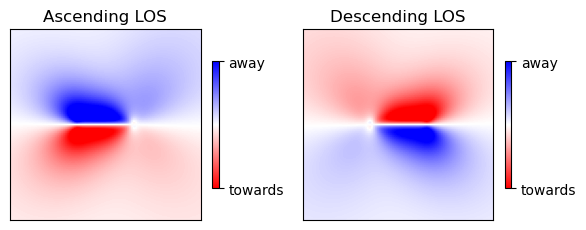

In [78]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker

base_cmap = LinearSegmentedColormap.from_list('custom diverging', ['#FF0000', '#FFFFFF', '#0000FF'], N=256)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
asc_base = ax1.imshow(ULOS_ASC.T, cmap=base_cmap, vmin=-0.2, vmax=0.2)
ax1.set(title='Ascending LOS', xticks=[], yticks=[])
dsc_base = ax2.imshow(ULOS_DSC.T, cmap=base_cmap, vmin=-0.2, vmax=0.2)
ax2.set(title='Descending LOS', xticks=[], yticks=[])
f.colorbar(asc_base, ax=ax1, shrink=0.6, ticks=[-0.2, 0.2], format=mticker.FixedFormatter(['towards', 'away']))
f.colorbar(dsc_base, ax=ax2, shrink=0.6, ticks=[-0.2, 0.2], format=mticker.FixedFormatter(['towards', 'away']))
f.patch.set_alpha(0.0)
plt.tight_layout()
plt.savefig('base_okada.svg', dpi=300)

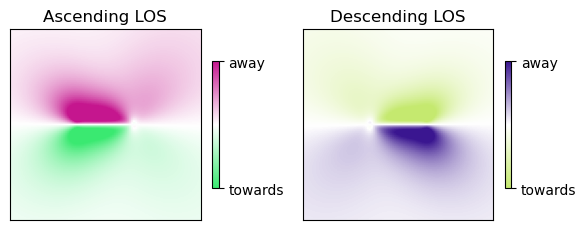

In [79]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker

asc_cmap = LinearSegmentedColormap.from_list('custom diverging', ['#3AE971', '#FFFFFF', '#C5168E'], N=256)
dsc_cmap = LinearSegmentedColormap.from_list('custom diverging', ['#C5E96F', '#FFFFFF', '#3A1690'], N=256)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
asc_new = ax1.imshow(ULOS_ASC.T, cmap=asc_cmap, vmin=-0.2, vmax=0.2)
ax1.set(title='Ascending LOS', xticks=[], yticks=[])
dsc_new = ax2.imshow(ULOS_DSC.T, cmap=dsc_cmap, vmin=-0.2, vmax=0.2)
ax2.set(title='Descending LOS', xticks=[], yticks=[])
f.colorbar(asc_new, ax=ax1, shrink=0.6, ticks=[-0.2, 0.2], format=mticker.FixedFormatter(['towards', 'away']))
f.colorbar(dsc_new, ax=ax2, shrink=0.6, ticks=[-0.2, 0.2], format=mticker.FixedFormatter(['towards', 'away']))
f.patch.set_alpha(0.0)
plt.tight_layout()
plt.savefig('new_okada.svg', dpi=300)

In [80]:
def create_mogi(size, delta_V):
    # Define Mogi source parameters
    # delta_V = 100.0  # Volume change (cubic meters)
    depth = 5.0    # Depth of the source (meters)
    nu = 0.25      # Poisson's ratio
    
    # Create a grid of (x, y) coordinates
    x = np.linspace(-10, 10, size)  # Adjust the range and resolution as needed
    y = np.linspace(-10, 10, size)
    X, Y = np.meshgrid(x, y)

    # Calculate surface displacements for each point in the grid
    mogi = (delta_V / (np.pi * (1 - nu))) * (depth / (X**2 + Y**2 + depth**2)**(3/2))
    return mogi

In [81]:
mogi = create_mogi(100, 100)
asc_mogi = mogi * p_vec_asc[2]
dsc_mogi = mogi * p_vec_dsc[2]

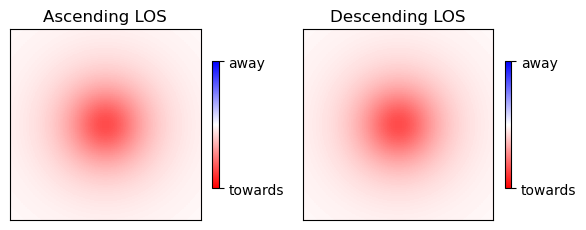

In [82]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker

f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
asc_base = ax1.imshow(asc_mogi, cmap=base_cmap, vmin=-2, vmax=2)
ax1.set(title='Ascending LOS', xticks=[], yticks=[])
dsc_base = ax2.imshow(dsc_mogi, cmap=base_cmap, vmin=-2, vmax=2)
ax2.set(title='Descending LOS', xticks=[], yticks=[])
f.colorbar(asc_base, ax=ax1, shrink=0.6, ticks=[-2, 2], format=mticker.FixedFormatter(['towards', 'away']))
f.colorbar(dsc_base, ax=ax2, shrink=0.6, ticks=[-2, 2], format=mticker.FixedFormatter(['towards', 'away']))
f.patch.set_alpha(0.0)
plt.tight_layout()
plt.savefig('base_mogi.svg', dpi=300)

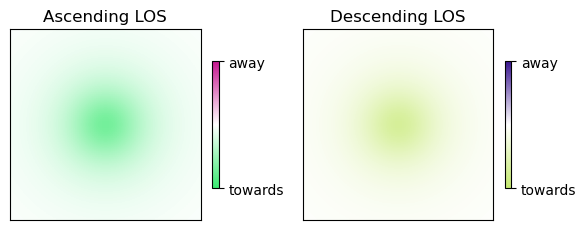

In [84]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker

f, (ax1, ax2) = plt.subplots(1,2, figsize=(6,2.5))
asc_base = ax1.imshow(asc_mogi, cmap=asc_cmap, vmin=-2, vmax=2)
ax1.set(title='Ascending LOS', xticks=[], yticks=[])
dsc_base = ax2.imshow(dsc_mogi, cmap=dsc_cmap, vmin=-2, vmax=2)
ax2.set(title='Descending LOS', xticks=[], yticks=[])
f.colorbar(asc_base, ax=ax1, shrink=0.6, ticks=[-2, 2], format=mticker.FixedFormatter(['towards', 'away']))
f.colorbar(dsc_base, ax=ax2, shrink=0.6, ticks=[-2, 2], format=mticker.FixedFormatter(['towards', 'away']))
f.patch.set_alpha(0.0)
plt.tight_layout()
plt.savefig('new_mogi.svg', dpi=300)

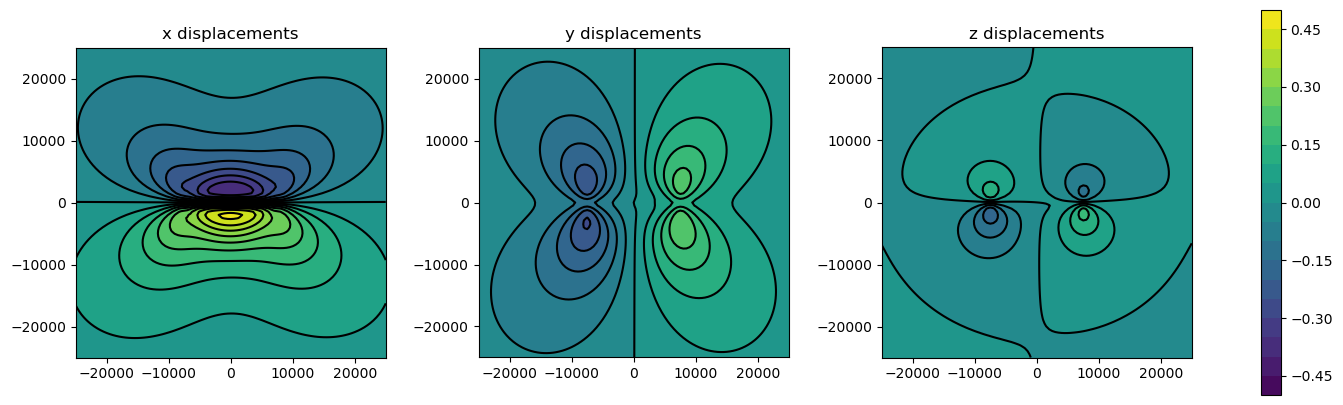

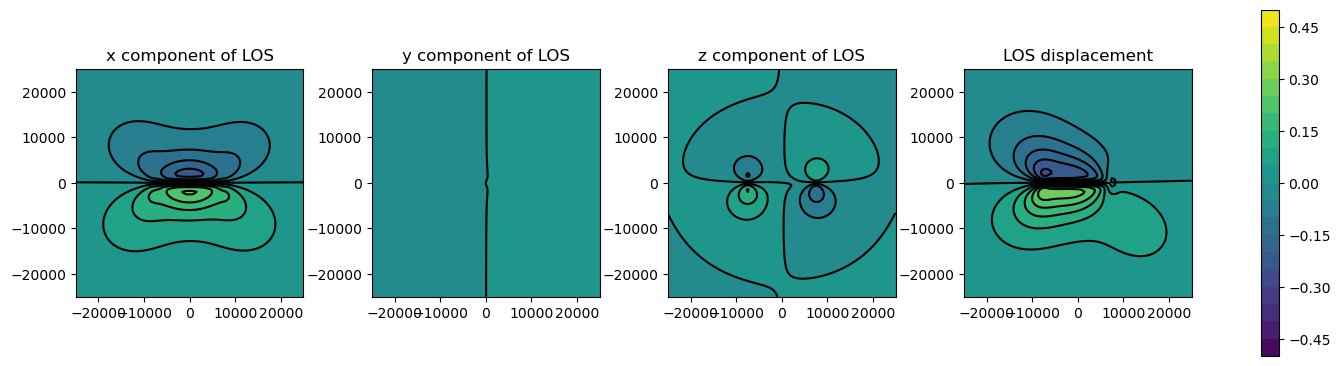

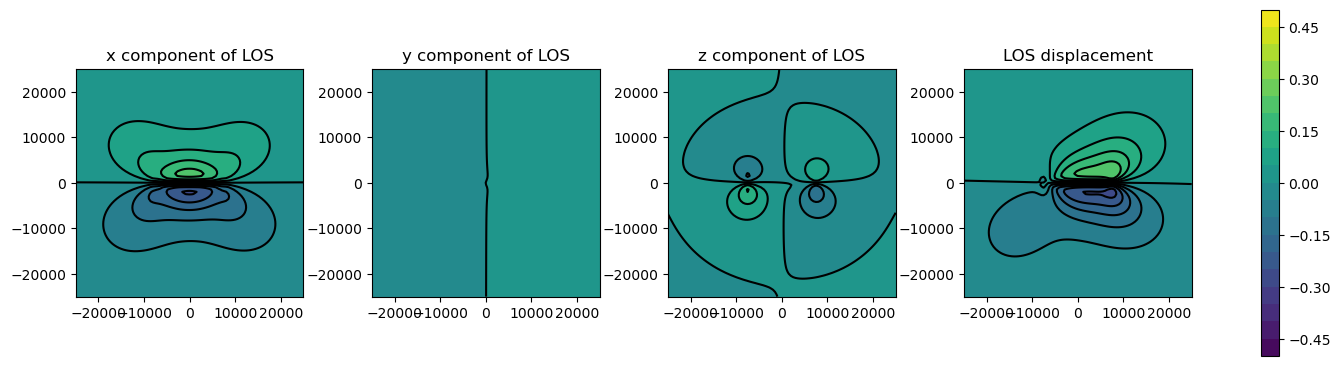

In [44]:
# and now, plot all the things!

# first, the unscaled displacements
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,5))  # set up three subplots (size in x and y)
fig.subplots_adjust(wspace=0.3)                            # space them out a little

axlist = [ax1,ax2,ax3]   # handles for your subplots

levels = linspace(-0.5, 0.5, 21)   # the bounds of your color scale - adjust if necessary

cntrf = ax1.contourf(x, y, UX.T, levels = levels)
first = ax1.contour(x, y, UX.T, colors = 'k', levels = levels, linestyles = 'solid')
ax1.axis('image')
ax1.title.set_text('x displacements')

cntrf = ax2.contourf(x, y, UY.T, levels = levels)
second = ax2.contour(x, y, UY.T, colors = 'k', levels = levels, linestyles = 'solid')
ax2.axis('image')
ax2.title.set_text('y displacements')

cntrf = ax3.contourf(x, y, UZ.T, levels = levels)
third = ax3.contour(x, y, UZ.T, colors = 'k', levels = levels, linestyles = 'solid')
ax3.axis('image')
ax3.title.set_text('z displacements')

fig.colorbar(cntrf, ax=axlist)

plt.show()

# next the ascending interferogram and components
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(18,4.5))  # set up four subplots (size in x and y)
fig.subplots_adjust(wspace=0.3)                            # space them out a little

axlist = [ax1,ax2,ax3,ax4]   # handles for your subplots

levels = linspace(-0.5, 0.5, 21)   # the bounds of your color scale - adjust if necessary

cntrf = ax1.contourf(x, y, ULOS_ASC_X.T, levels = levels)
first = ax1.contour(x, y, ULOS_ASC_X.T, colors = 'k', levels = levels, linestyles = 'solid')
ax1.axis('image')
ax1.title.set_text('x component of LOS')

cntrf = ax2.contourf(x, y, ULOS_ASC_Y.T, levels = levels)
second = ax2.contour(x, y, ULOS_ASC_Y.T, colors = 'k', levels = levels, linestyles = 'solid')
ax2.axis('image')
ax2.title.set_text('y component of LOS')

cntrf = ax3.contourf(x, y, ULOS_ASC_Z.T, levels = levels)
third = ax3.contour(x, y, ULOS_ASC_Z.T, colors = 'k', levels = levels, linestyles = 'solid')
ax3.axis('image')
ax3.title.set_text('z component of LOS')

cntrf = ax4.contourf(x, y, ULOS_ASC.T, levels = levels)
third = ax4.contour(x, y, ULOS_ASC.T, colors = 'k', levels = levels, linestyles = 'solid')
ax4.axis('image')
ax4.title.set_text('LOS displacement')

fig.colorbar(cntrf, ax=axlist)

plt.show()

# finally, the descending interferogram and components
fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(18,4.5))  # set up four subplots (size in x and y)
fig.subplots_adjust(wspace=0.3)                            # space them out a little

axlist = [ax1,ax2,ax3,ax4]   # handles for your subplots

levels = linspace(-0.5, 0.5, 21)   # the bounds of your color scale - adjust if necessary

cntrf = ax1.contourf(x, y, ULOS_DSC_X.T, levels = levels)
first = ax1.contour(x, y, ULOS_DSC_X.T, colors = 'k', levels = levels, linestyles = 'solid')
ax1.axis('image')
ax1.title.set_text('x component of LOS')

cntrf = ax2.contourf(x, y, ULOS_DSC_Y.T, levels = levels)
second = ax2.contour(x, y, ULOS_DSC_Y.T, colors = 'k', levels = levels, linestyles = 'solid')
ax2.axis('image')
ax2.title.set_text('y component of LOS')

cntrf = ax3.contourf(x, y, ULOS_DSC_Z.T, levels = levels)
third = ax3.contour(x, y, ULOS_DSC_Z.T, colors = 'k', levels = levels, linestyles = 'solid')
ax3.axis('image')
ax3.title.set_text('z component of LOS')

cntrf = ax4.contourf(x, y, ULOS_DSC.T, levels = levels)
third = ax4.contour(x, y, ULOS_DSC.T, colors = 'k', levels = levels, linestyles = 'solid')
ax4.axis('image')
ax4.title.set_text('LOS displacement')

fig.colorbar(cntrf, ax=axlist)

plt.show()